### Edgar Moises Hernandez-Gonzalez
#### 09/04/20-11/04/20
#### Clasificacion de imagenes motoras en EEG con Transfer Learning
##### Caracteristicas = Espectrogramas STFFT (3D)
##### Concatenacion vertical

##### VGG16
##### Sujeto 1
##### Accuracy = 50.00%
##### Kappa = 0.3333

##### MobileNetV2
##### Sujeto 1
##### Accuracy = 44.10%
##### Kappa = 0.2546

##### NasNetLarge
##### Sujeto 1
##### Accuracy = 47%
##### Kappa = 0.

##### InceptionResNetV2
##### Sujeto 1
##### Accuracy = 45%
##### Kappa = 0.

##### Xception
##### Sujeto 1
##### Accuracy = 46%
##### Kappa = 0.

##### InceptionV3
##### Sujeto 1
##### Accuracy = 50.00%
##### Kappa = 0.3333

##### InceptionV3 + LSTM
##### Sujeto 1
##### Accuracy = 45.83%
##### Kappa = 0.2778

In [0]:
from google.colab import drive

In [2]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import cohen_kappa_score, confusion_matrix
from scipy.signal import spectrogram
import cv2
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout, LSTM
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K

In [2]:
# para que este script funcione debe de decir 'channels_last', si dice 'channels_first' no sirve
K.image_data_format()

'channels_last'

In [0]:
x_train = pd.read_csv("/content/drive/My Drive/BCI-IV-2a/RAW/MI-EEG-A01T.csv", header=None)
x_test = pd.read_csv("/content/drive/My Drive/BCI-IV-2a/RAW/MI-EEG-A01E.csv", header=None)
y_train = pd.read_csv("/content/drive/My Drive/BCI-IV-2a/RAW/EtiquetasA01T.csv", header=None)
y_test = pd.read_csv("/content/drive/My Drive/BCI-IV-2a/RAW/EtiquetasA01E.csv", header=None)

In [4]:
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(288, 22000)
(288, 22000)
(288, 1)
(288, 1)


In [5]:
n_samples_train = len(y_train)
n_samples_test = len(y_test) #en caso de no tener el y_test se puede utilizar el x_test

print("n_samples_train:", n_samples_train)
print("n_samples_test :", n_samples_test)

n_samples_train: 288
n_samples_test : 288


In [6]:
n_classes = len(np.unique(y_test)) #esto se podria calcular asi n_clases = len(np.unique(y)), la y puede ser train o test

print("n_classes:", n_classes)

n_classes: 4


In [7]:
#codificar etiquetas con valores de 0 a nClases-1
le = LabelEncoder().fit(y_train)
y_train = le.transform(y_train)
y_test = le.transform(y_test)

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [0]:
#unir 22 canales y resize de tamaño proporcional
def unir_espectrogramas_vertical_resize(data):
  dim = (299, 299) #ancho, alto
  fs = 250
  datos = np.zeros((288,299,299,3))
  temporal = np.zeros((528,4,3))
  for i in range(data.shape[0]): #288 muestras
    for j in range(22): #22 canales
      sig = data.iloc[i, j*1000:(j+1)*1000]
      f, t, Sxx = spectrogram(sig, fs) #espectrograma de STFFT
      temporal[j*24:(j+1)*24, :, 0] = Sxx[8:32, :]
      temporal[j*24:(j+1)*24, :, 1] = Sxx[8:32, :]
      temporal[j*24:(j+1)*24, :, 2] = Sxx[8:32, :]
    resized = cv2.resize(temporal, dim, interpolation=cv2.INTER_AREA)
    datos[i] = resized
  return datos

In [0]:
#llamar a unir_espectrogramas_vertical_resize(data)
x_train = unir_espectrogramas_vertical_resize(x_train)
x_test = unir_espectrogramas_vertical_resize(x_test)

In [10]:
print(x_train.shape)
print(x_test.shape)

(288, 299, 299, 3)
(288, 299, 299, 3)


In [11]:
print(np.max(x_train))
print(np.max(x_test))
print(np.min(x_train))
print(np.min(x_test))
print(np.mean(x_train))
print(np.mean(x_test))

124.52351832617315
88.18918136153654
0.0006962254188471109
0.00013698288039382033
1.171795813706635
1.1849465019572498


In [0]:
#convertir a float
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

#escalar los valores en un rango de 0 a 1 (normalizar)
x_train /= 125.0
x_test /= 125.0

In [13]:
print(np.max(x_train))
print(np.max(x_test))
print(np.min(x_train))
print(np.min(x_test))
print(np.mean(x_train))
print(np.mean(x_test))

0.99618816
0.7055134
5.5698033e-06
1.095863e-06
0.009374359
0.009479575


In [0]:
base_model = InceptionV3(weights='imagenet',
                   include_top=False,
                   input_shape=x_train.shape[1:])

In [15]:
base_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 149, 149, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 149, 149, 32) 0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [16]:
#Extraccion de caracteristicas con VGG16
x_train = base_model.predict(x_train)
print(x_train.shape)

x_test = base_model.predict(x_test)
print(x_test.shape)

(288, 8, 8, 2048)
(288, 8, 8, 2048)


In [17]:
print(x_train[0,:,:,0].shape)
print(x_train[0,:,:,0])

(8, 8)
[[0.         0.         0.         0.         0.         0.34024605
  0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.        ]
 [0.06884426 0.         0.         0.         0.         0.
  0.         0.24952814]
 [0.13019533 0.         0.         0.         0.00522814 0.
  0.4149631  0.00224635]
 [0.         0.         0.         0.         0.         0.
  0.         0.        ]
 [0.01454768 0.         0.         0.         0.         0.
  0.04387344 0.26953173]
 [0.         0.         0.         0.         0.         0.21937244
  0.6971147  0.53967094]
 [0.         0.         0.         0.         0.         0.
  0.         0.        ]]


In [18]:
x_train = x_train.reshape((x_train.shape[0], x_train.shape[1] * x_train.shape[2], x_train.shape[3]))
x_test = x_test.reshape((x_test.shape[0], x_test.shape[1] * x_test.shape[2], x_test.shape[3]))

print(x_train.shape)
print(x_test.shape)

(288, 64, 2048)
(288, 64, 2048)


In [20]:
print(x_train[0,:,0].shape)
print(x_train[0,:,0])

(64,)
[0.         0.         0.         0.         0.         0.34024605
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.06884426 0.
 0.         0.         0.         0.         0.         0.24952814
 0.13019533 0.         0.         0.         0.00522814 0.
 0.4149631  0.00224635 0.         0.         0.         0.
 0.         0.         0.         0.         0.01454768 0.
 0.         0.         0.         0.         0.04387344 0.26953173
 0.         0.         0.         0.         0.         0.21937244
 0.6971147  0.53967094 0.         0.         0.         0.
 0.         0.         0.         0.        ]


In [0]:
def transfer_learning():
  model = Sequential()
  model.add(Flatten(input_shape=x_train.shape[1:]))
  model.add(Dense(64, activation='relu'))
  model.add(Dropout(0.2))
  model.add(Dense(n_classes, activation='softmax'))

  optimizer = Adam(lr=1e-4)
  model.compile(optimizer = optimizer,
                loss = 'sparse_categorical_crossentropy',
                metrics = ['accuracy'])
  return model

In [0]:
def transfer_learning_rnn():
  model = Sequential()
  model.add(LSTM(256,
                 dropout=0.5,
                 input_shape=x_train.shape[1:]))
  #model.add(Dropout(0.5))
  model.add(Dense(16, activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(n_classes, activation='softmax'))

  optimizer = Adam(lr=1e-5)
  model.compile(optimizer = optimizer,
                loss = 'sparse_categorical_crossentropy',
                metrics = ['accuracy'])
  return model

Iteration: 1
9/9 - 0s - loss: 1.1855 - accuracy: 0.4479
kappa:  0.26388888888888884
confusion matrix:
 [[26 25 17  4]
 [18 33 14  7]
 [ 5  9 31 27]
 [ 4  4 25 39]]


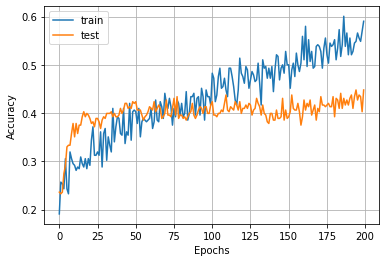

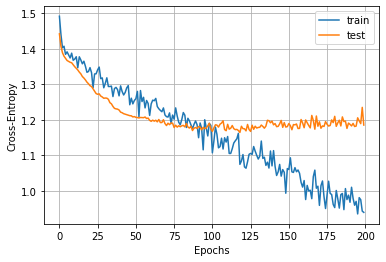

Iteration: 2
9/9 - 0s - loss: 1.3290 - accuracy: 0.4062
kappa:  0.20833333333333337
confusion matrix:
 [[32 29  7  4]
 [23 36  4  9]
 [10 17 17 28]
 [ 9  4 27 32]]


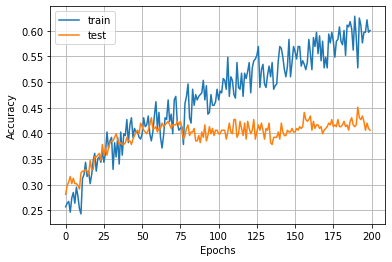

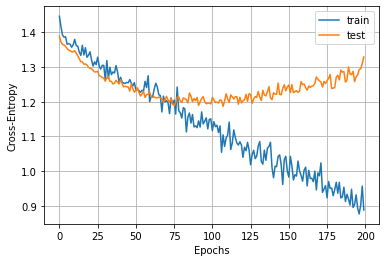

Iteration: 3
9/9 - 0s - loss: 1.2295 - accuracy: 0.4549
kappa:  0.27314814814814814
confusion matrix:
 [[40 15 11  6]
 [33 21 11  7]
 [ 9 10 23 30]
 [ 6  5 14 47]]


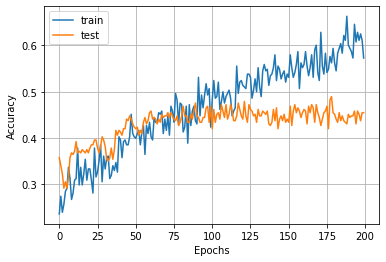

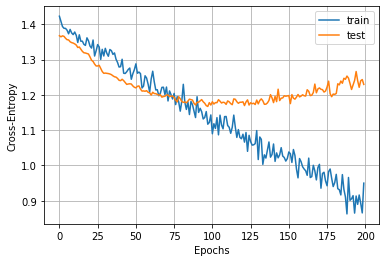

Iteration: 4
9/9 - 0s - loss: 1.2365 - accuracy: 0.4201
kappa:  0.22685185185185186
confusion matrix:
 [[30 24 12  6]
 [30 24 10  8]
 [ 7 13 28 24]
 [ 5  3 25 39]]


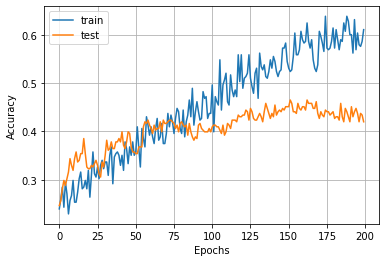

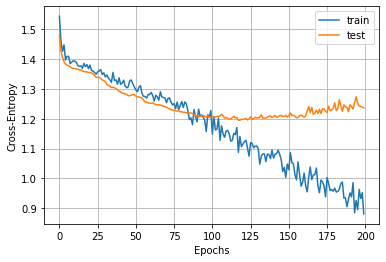

Iteration: 5
9/9 - 0s - loss: 1.2442 - accuracy: 0.4583
kappa:  0.2777777777777778
confusion matrix:
 [[49 13  5  5]
 [42 18  3  9]
 [18  8 15 31]
 [10  2 10 50]]


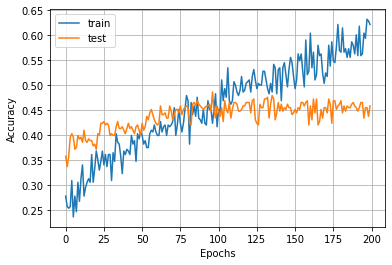

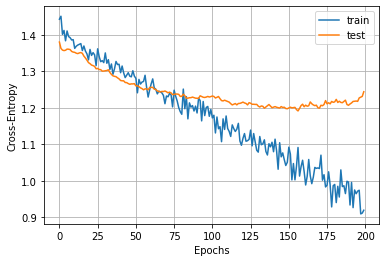


Resultados:
loss: [1.1854625940322876, 1.3289676904678345, 1.2294889688491821, 1.2364929914474487, 1.244234561920166]
accuracy: [0.4479166567325592, 0.40625, 0.4548611044883728, 0.4201388955116272, 0.4583333432674408]
kappa: [0.26388888888888884, 0.20833333333333337, 0.27314814814814814, 0.22685185185185186, 0.2777777777777778]


In [54]:
array_loss = []
array_acc = []
array_kappa = []
for i in range(5):
  print("Iteration:", i+1)
    
  model = transfer_learning_rnn()

  history = model.fit(x_train, y_train, epochs=200, batch_size=18,
                      validation_data=(x_test, y_test), verbose=0)
    
  test_loss, test_acc = model.evaluate(x_test, y_test, verbose=2)
  array_loss.append(test_loss)
  array_acc.append(test_acc)
    
  probabilidades = model.predict(x_test)
  y_pred = np.argmax(probabilidades, 1) #1=fila
    
  kappa = cohen_kappa_score(y_test, y_pred)
  array_kappa.append(kappa)
  print("kappa: ", kappa)
    
  matriz_confusion = confusion_matrix(y_test, y_pred)
  print("confusion matrix:\n", matriz_confusion)
    
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.grid()
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend(['train', 'test'])
  plt.show()
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.grid()
  plt.xlabel('Epochs')
  plt.ylabel('Cross-Entropy')
  plt.legend(['train', 'test'])
  plt.show()
    
print() 
print("Resultados:")
print("loss:", array_loss)
print("accuracy:", array_acc)
print("kappa:", array_kappa)

In [55]:
model.summary()

Model: "sequential_29"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_29 (LSTM)               (None, 256)               2360320   
_________________________________________________________________
dense_58 (Dense)             (None, 16)                4112      
_________________________________________________________________
dropout_43 (Dropout)         (None, 16)                0         
_________________________________________________________________
dense_59 (Dense)             (None, 4)                 68        
Total params: 2,364,500
Trainable params: 2,364,500
Non-trainable params: 0
_________________________________________________________________


In [56]:
print("Mean Accuracy: %.4f" % np.mean(array_acc))
print("std: (+/- %.4f)" % np.std(array_acc))
print("Mean Kappa: %.4f" % np.mean(array_kappa))
print("std: (+/- %.4f)" % np.std(array_kappa))
print("Max Accuracy: %.4f" % np.max(array_acc))
print("Max Kappa: %.4f" % np.max(array_kappa))

Mean Accuracy: 0.4375
std: (+/- 0.0206)
Mean Kappa: 0.2500
std: (+/- 0.0275)
Max Accuracy: 0.4583
Max Kappa: 0.2778
